#### Задачи проекта
Предполагается, что в ходе работы над проектом будут решены следующие задачи:
* Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
* Предобработка данных. Будьте внимательны: в данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
* Обучение модели
* Подготовка предсказания на тестовой выборке. Обратите внимание. Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”. 
* Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
* Написание инструмента для тестирования
* Оформление документации

###### Описание исходных данных:

Данные пациентов для предсказания риска сердечных приступов:
*id  - id
*Антропометрические параметры (вес, возраст, рост)
*Привычки (курение, качество сна и т.д)
*Давление
*Наличие хронических заболеваний
*Биохимия крови
*Таргет - высокий или низкий риск поражения сердца

data:
* Безымянный
* Возраст 
* холестерин 
* Частота сердечных сокращений 
* Сахарный диабет 
* Семейный анамнез 
* Курение
* Ожирение 
* Употребление алкоголя
* Часов физических упражнений в Неделю 
* Диета 
* Предыдущие проблем с сердцем 
* Использование медикаментов 
* Уровень стресса 
* Часы сидячего образа жизни в день
* Доход 
* ИМТ (индекс массы тела)
* Триглицериды
* Дней физической активности в Неделю 
* Часы сна в день
* Риск сердечного приступа (бинарный) 
* Уровень сахара в крови 
* ck - mb (креатинфосфокиназа-МВ)
* Тропонин 
* Пол 
* Артериальное давление
* id


## Загрузка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
import shap
import os
import io
import warnings
import joblib

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

warnings.filterwarnings('ignore')

In [2]:
# загрузим данные
def load_data():  
    train_df = pd.read_csv('heart_train.csv', decimal='.', sep=',')
    test_df = pd.read_csv('heart_test.csv', decimal='.', sep=',')

    return train_df, test_df

train_df, test_df = load_data()

In [3]:
#проверим основную информацию по загруженным данным

train_df.info()
print(f"Размер: {train_df.shape}")
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [4]:
#проверим основную информацию по загруженным test данным

test_df.info()
print(f"Размер: {test_df.shape}")
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


###### Вывод: 
Данные выглядят странно, это нормализованные данные (вероятно, все признаки масштабированы в диапазон 0,1). Давайте разберемся, что не так с данными:
1. Нормализация/Стандартизация (примеры странных значений):
Age = 0.359551 - возраст от 0 до 1, 
Cholesterol = 0.732143 - холестерин от 0 до 1,
Heart rate = 0.074244 - пульс от 0 до 1.

2. Бинарные признаки тоже масштабированы:
Diabetes = 0.0 или 1.0 - но должен быть 0 или 1
Family History = 1.0  - float вместо int

3. Категориальные признаки не обработаны, критическая проблема:
Gender значения: ['Male', 'Female', '1.0', '0.0'] - это смешение типов, в столбце Gender есть:

Строки: 'Male', 'Female', 
Числа как строки: '1.0', '0.0', 
Возможно также числа как float: 1.0, 0.0.

Это означает, что данные неконсистентны - кто-то уже пытался кодировать этот признак, но сделал это частично. Будем это исправлять.

Проблемы, которые вижу:

Слишком агрессивная нормализация - даже бинарные признаки стали float

Потеря интерпретируемости - непонятно, что значит Age=0.359551

Смешение типов - где-то 0/1, где-то дробные числа

Принято решение - работать с нормализованными данными как есть.

Преимущество: уже готово для моделей машинного обучения

Недостаток: сложно интерпретировать

## Предварительная предобработка данных

In [5]:
# изменим название столбцов
train_df.columns = train_df.columns.str.replace(' ', '_')
test_df.columns = test_df.columns.str.replace(' ', '_')


In [6]:
def columns_to_lowercase(df, df_name="датафрейма"):
    original_columns = df.columns.tolist()
    df.columns = df.columns.str.lower()
    changed = sum(1 for orig, new in zip(original_columns, df.columns) if orig != new)
    
    print(f" Приведены к нижнему регистру в {df_name}: {changed} столбцов")
    return df
    
train_df = columns_to_lowercase(train_df, "train_df")
test_df = columns_to_lowercase(test_df, "test_df")

 Приведены к нижнему регистру в train_df: 27 столбцов
 Приведены к нижнему регистру в test_df: 26 столбцов


In [7]:
#проверим на дубликаты
full_duplicates = train_df.duplicated().sum()
print(f" Полных дубликатов: {full_duplicates}")

full_duplicates_1 = test_df.duplicated().sum()
print(f" Полных дубликатов: {full_duplicates_1}")

 Полных дубликатов: 0
 Полных дубликатов: 0


In [8]:
# проверим на пропуски 
print(f"\n Пропуски в train: {train_df.isnull().sum().sum()}")
print(f" Пропуски в test:  {test_df.isnull().sum().sum()}")


 Пропуски в train: 2187
 Пропуски в test:  279


In [9]:
# исправим Gender (смешанные типы)
if 'gender' in train_df.columns:
    train_df['gender'] = train_df['gender'].astype(str)
    gender_map = {'male': 0, 'female': 1, '1.0': 0, '0.0': 1, '1': 0, '0': 1}
    train_df['gender'] = train_df['gender'].str.lower().map(gender_map).fillna(0)

In [10]:
train_df['gender'].unique()

array([0, 1], dtype=int64)

In [11]:
# бинарные признаки: float → int
binary_cols = ['diabetes', 'family_history', 'smoking', 'obesity',
                   'alcohol_consumption', 'previous_heart_problems', 
                   'medication_use']
    
for col in binary_cols:
    if col in train_df.columns:
            train_df[col] = train_df[col].fillna(train_df[col].median()).round().astype(int)


In [12]:
# удалим ненужный столбец
train_df = train_df.drop(columns=['income'])
test_df = test_df.drop(columns=['income'])


###### Вывод:
В предобработке данных мы исправили название столбцов в обоих датасетах, для локаничности и удоства работы в дальнейшем. Проверили на пропуски в train: 2187, в test:  279 - заполним медианным значением перед подготовкой модели. Дублей нет. Исправили столбец 'Gender', так же бинарные признаки привели к значению int. Удалили ненужный столбец - 'income', убираем потенциальный шум.

## Исследовательский анализ данных

In [13]:
# настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [14]:
#базовая описательная статистика
def basic_statistics(train_df, test_df):

    print("ОСНОВНАЯ СТАТИСТИКА")
    print("-" * 40)
    
    print(f"Размеры данных:")
    print(f"  Train: {train_df.shape[0]} строк, {train_df.shape[1]} столбцов")
    print(f"  Test:  {test_df.shape[0]} строк, {test_df.shape[1]} столбцов")
    
    # пропущенные значения
    print(f"\nПропущенные значения:")
    train_missing = train_df.isnull().sum().sum()
    test_missing = test_df.isnull().sum().sum()
    print(f"  Train: {train_missing} ({train_missing/train_df.size*100:.2f}%)")
    print(f"  Test:  {test_missing} ({test_missing/test_df.size*100:.2f}%)")
    
    # целевая переменная
    if 'heart_attack_risk_(binary)' in train_df.columns:
        target_dist = train_df['heart_attack_risk_(binary)'].value_counts()
        print(f"\nРаспределение целевой переменной:")
        print(f"  0 (нет риска): {target_dist[0]} ({target_dist[0]/len(train_df)*100:.1f}%)")
        print(f"  1 (есть риск): {target_dist[1]} ({target_dist[1]/len(train_df)*100:.1f}%)")
    
    return train_df, test_df

In [15]:
# анализ типов данных и аномалий
def analyze_data_types(train_df, test_df):
    print("\n АНАЛИЗ ТИПОВ ДАННЫХ")
    print("-" * 40)
    

    print(" Train типы данных:")
    train_dtypes = train_df.dtypes.value_counts()
    for dtype, count in train_dtypes.items():
        print(f"  {dtype}: {count} столбцов")
    

    print("\n Test типы данных:")
    test_dtypes = test_df.dtypes.value_counts()
    for dtype, count in test_dtypes.items():
        print(f"  {dtype}: {count} столбцов")
    
    # проверка аномалий в Gender
    print("\n  Проверка аномалий:")
    if 'gender' in train_df.columns:
        print(f"  Train Gender уникальные значения: {train_df['gender'].unique()}")
    if 'gender' in test_df.columns:
        print(f"  Test Gender уникальные значения: {test_df['gender'].unique()}")
    
    return train_df, test_df

In [16]:
#выявление выбросов по правилу 1.5*IQR
def detect_outliers(df, df_name="данных"):
    print(f"\n ВЫБРОСЫ В {df_name.upper()}:")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outliers_report = {}
    
    for col in numeric_cols[:10]:  
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        
        if outlier_count > 0:
            outliers_report[col] = {
                'count': outlier_count,
                'percent': outlier_count/len(df)*100,
                'min': df[col].min(),
                'max': df[col].max()
            }
    
    if outliers_report:
        print(f"  Найдено выбросов в {len(outliers_report)} признаках:")
        for col, stats in list(outliers_report.items())[:5]:  
            print(f"    {col:30} {stats['count']:4} выбросов ({stats['percent']:.1f}%)")
    else:
        print("  Выбросов не обнаружено")
    
    return outliers_report

In [17]:
# корреляционный анализ
def correlation_analysis(train_df):
    print("\n КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
    print("-" * 40)
    
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) > 1:
        corr_matrix = train_df[numeric_cols].corr()
        
        strong_correlations = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr = abs(corr_matrix.iloc[i, j])
                if corr > 0.7:
                    col1 = corr_matrix.columns[i]
                    col2 = corr_matrix.columns[j]
                    strong_correlations.append((col1, col2, corr))
        
        if strong_correlations:
            print(" Сильные корреляции (|r| > 0.7):")
            for col1, col2, corr in strong_correlations[:5]:  
                print(f"  {col1:25} ↔ {col2:25} : {corr:.3f}")
        else:
            print(" Сильных корреляций не обнаружено")

        if 'heart_attack_risk_(binary)' in train_df.columns:
            target_corr = corr_matrix['heart_attack_risk_(binary)'].sort_values(ascending=False)
            print(f"\n Корреляция с целевой переменной:")
            for col, corr in list(target_corr.items())[1:6]:  
                direction = "положительная" if corr > 0 else "отрицательная"
                print(f"  {col:30} : {corr:.3f} ({direction})")
        
        return corr_matrix
    return None

In [18]:
# основная функция исследовательского анализа данных
def perform_eda(train_df, test_df):

    print("="*60)
    print("ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)")
    print("="*60)
    
    basic_statistics(train_df, test_df)
    
    analyze_data_types(train_df, test_df)
    
    print("\n ВЫЯВЛЕНИЕ ВЫБРОСОВ")
    print("-" * 40)
    train_outliers = detect_outliers(train_df, "Train")
    test_outliers = detect_outliers(test_df, "Test")
    
    corr_matrix = correlation_analysis(train_df)

    print("\n" + "="*60)
    print(" ИТОГОВЫЙ ОТЧЕТ EDA")
    print("="*60)
    
    report = {
        "Размер данных": f"Train: {train_df.shape}, Test: {test_df.shape}",
        "Пропуски": f"Train: {train_df.isnull().sum().sum()}, Test: {test_df.isnull().sum().sum()}",
        "Целевая переменная": f"Сбалансированность: {train_df['heart_attack_risk_(binary)'].value_counts().to_dict()}" if 'heart_attack_risk_(binary)' in train_df.columns else "N/A",
        "Выбросы": f"Train: {len(train_outliers)} признаков с выбросами, Test: {len(test_outliers)}",
        "Рекомендации": [
            "1. Заполнить пропуски в test_df",
            "2. Исправить тип данных gender в test_df",
            "3. Рассмотреть удаление сильных корреляций при построении модели"
        ]
    }
    
    for key, value in report.items():
        if isinstance(value, list):
            print(f"\n• {key}:")
            for item in value:
                print(f"  {item}")
        else:
            print(f"• {key}: {value}")
    
    return train_df, test_df

In [19]:
# запускаем полный EDA анализ
print("Начинаем исследовательский анализ данных")
train_df, test_df = perform_eda(train_df, test_df)

Начинаем исследовательский анализ данных
ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ (EDA)
ОСНОВНАЯ СТАТИСТИКА
----------------------------------------
Размеры данных:
  Train: 8685 строк, 27 столбцов
  Test:  966 строк, 26 столбцов

Пропущенные значения:
  Train: 486 (0.21%)
  Test:  279 (1.11%)

Распределение целевой переменной:
  0 (нет риска): 5672 (65.3%)
  1 (есть риск): 3013 (34.7%)

 АНАЛИЗ ТИПОВ ДАННЫХ
----------------------------------------
 Train типы данных:
  float64: 16 столбцов
  int32: 7 столбцов
  int64: 4 столбцов

 Test типы данных:
  float64: 22 столбцов
  int64: 3 столбцов
  object: 1 столбцов

  Проверка аномалий:
  Train Gender уникальные значения: [0 1]
  Test Gender уникальные значения: ['Male' 'Female' '1.0' '0.0']

 ВЫЯВЛЕНИЕ ВЫБРОСОВ
----------------------------------------

 ВЫБРОСЫ В TRAIN:
  Найдено выбросов в 2 признаках:
    heart_rate                        2 выбросов (0.0%)
    smoking                         820 выбросов (9.4%)

 ВЫБРОСЫ В TEST:
  Найдено выбро


 ГИСТОГРАММЫ РАСПРЕДЕЛЕНИЙ (TRAIN):
----------------------------------------


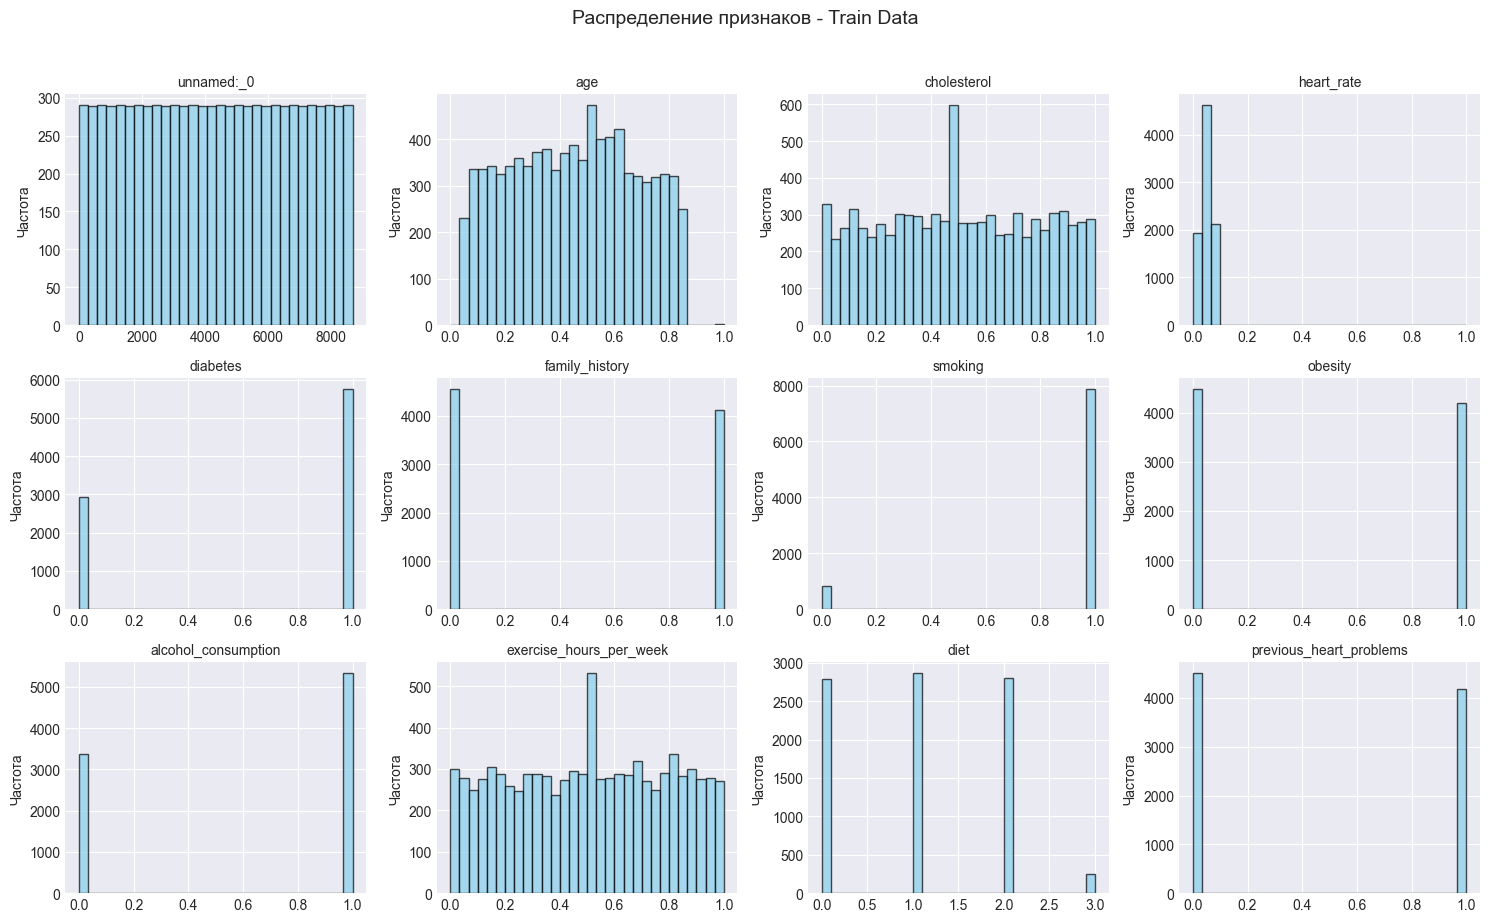


 ГИСТОГРАММЫ РАСПРЕДЕЛЕНИЙ (TEST):
----------------------------------------


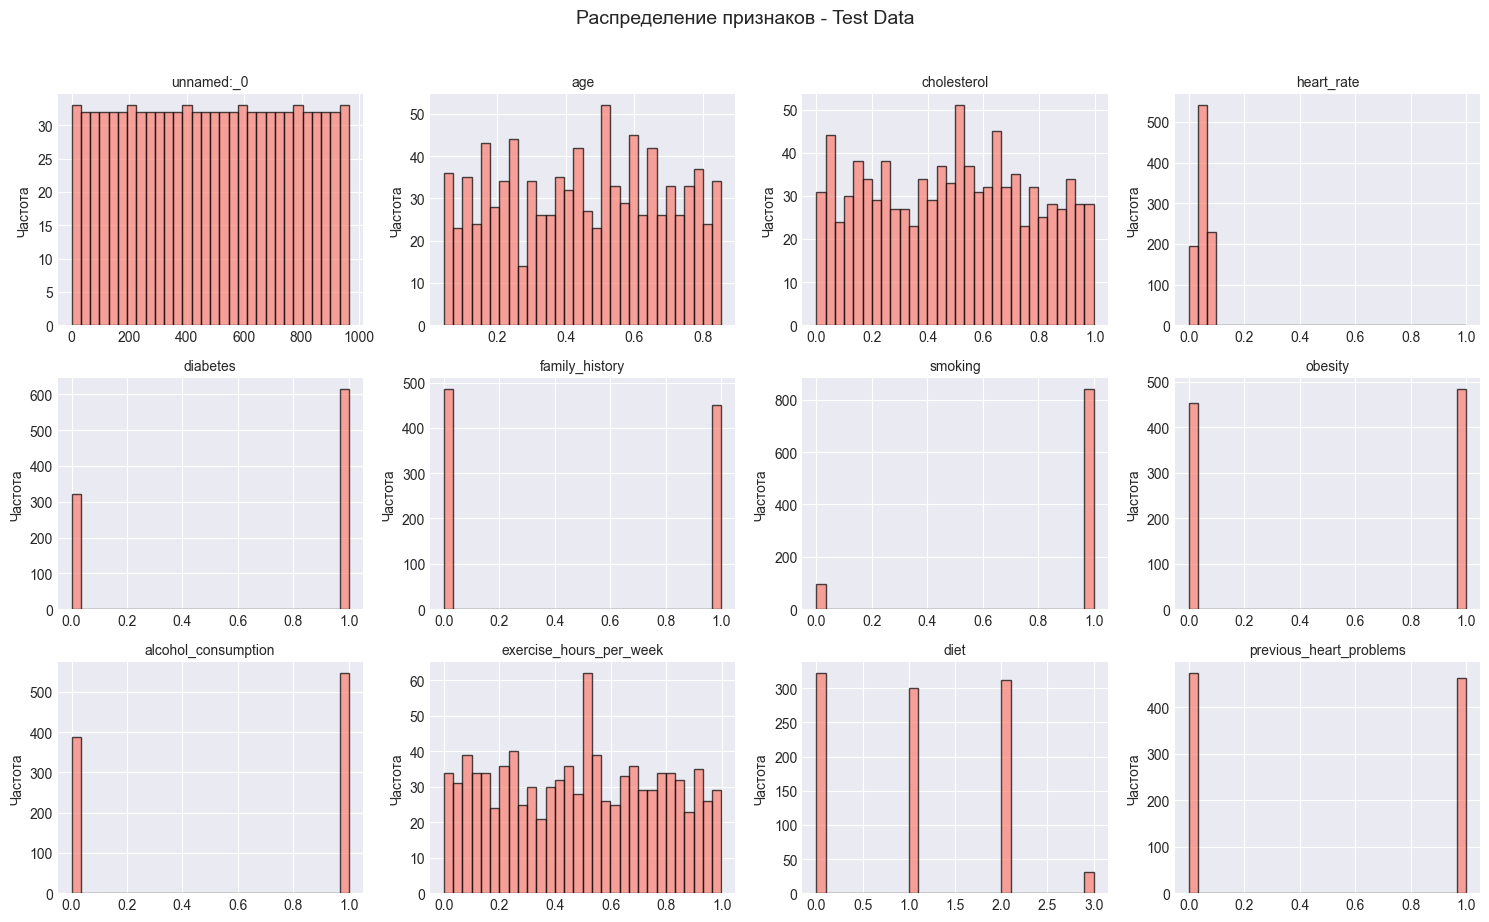

In [20]:
# построим гистограммы распределений
print("\n ГИСТОГРАММЫ РАСПРЕДЕЛЕНИЙ (TRAIN):")
print("-" * 40)

numeric_cols_train = train_df.select_dtypes(include=[np.number]).columns
plot_cols_train = numeric_cols_train[:12]  # Первые 12 признаков

n_cols = 4
n_rows = (len(plot_cols_train) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*3))
axes = axes.flatten()

for idx, col in enumerate(plot_cols_train):
    axes[idx].hist(train_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col}', fontsize=10)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Частота')


for idx in range(len(plot_cols_train), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Распределение признаков - Train Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n ГИСТОГРАММЫ РАСПРЕДЕЛЕНИЙ (TEST):")
print("-" * 40)

numeric_cols_test = test_df.select_dtypes(include=[np.number]).columns
plot_cols_test = numeric_cols_test[:12]

n_rows_test = (len(plot_cols_test) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows_test, n_cols, figsize=(15, n_rows_test*3))
axes = axes.flatten()

for idx, col in enumerate(plot_cols_test):
    axes[idx].hist(test_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='salmon')
    axes[idx].set_title(f'{col}', fontsize=10)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Частота')

for idx in range(len(plot_cols_test), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Распределение признаков - Test Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


 BOXPLOT ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ (TRAIN):
----------------------------------------


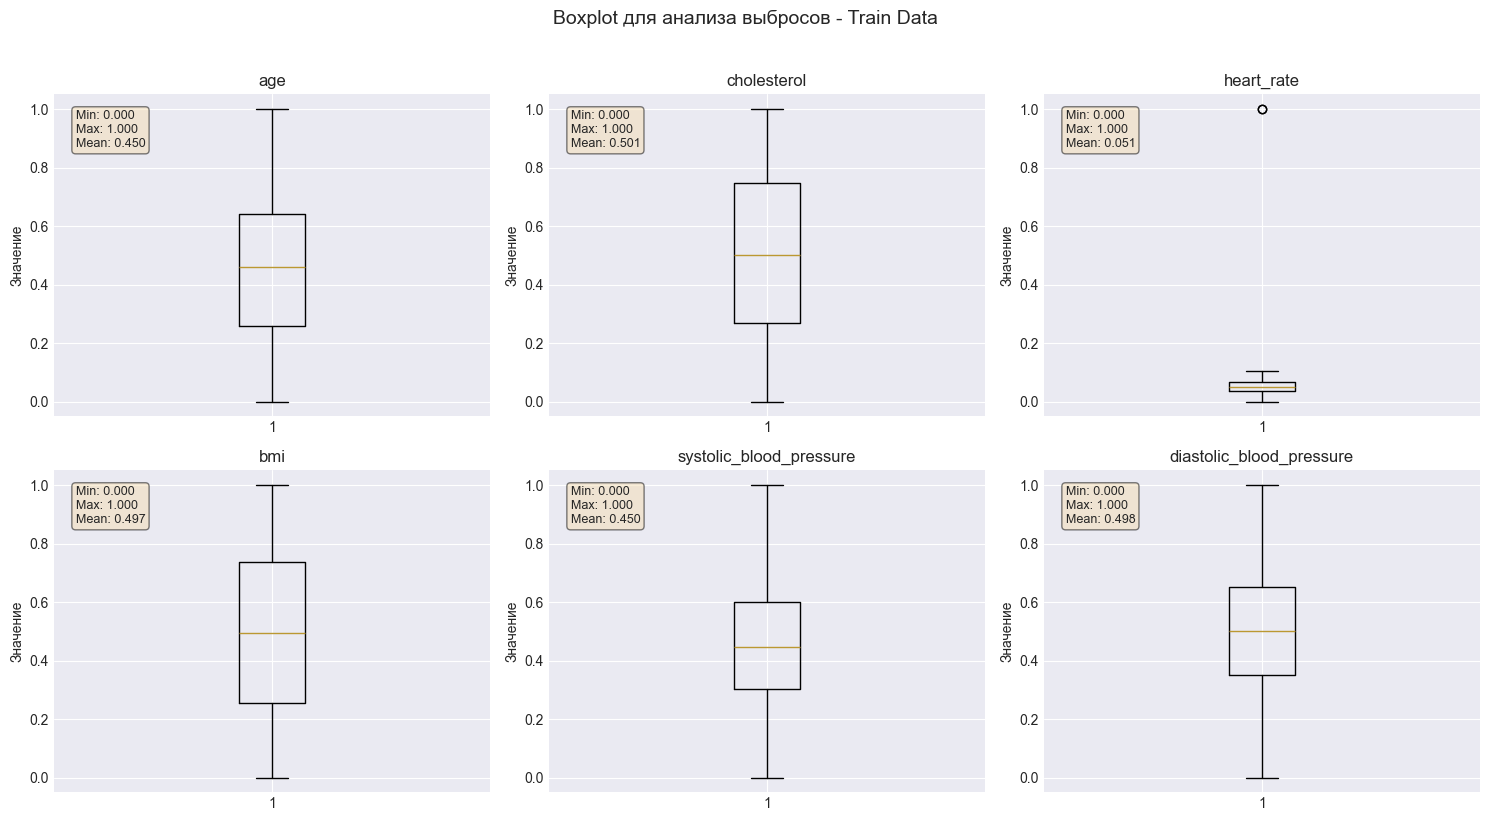


 BOXPLOT ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ (TEST):
----------------------------------------


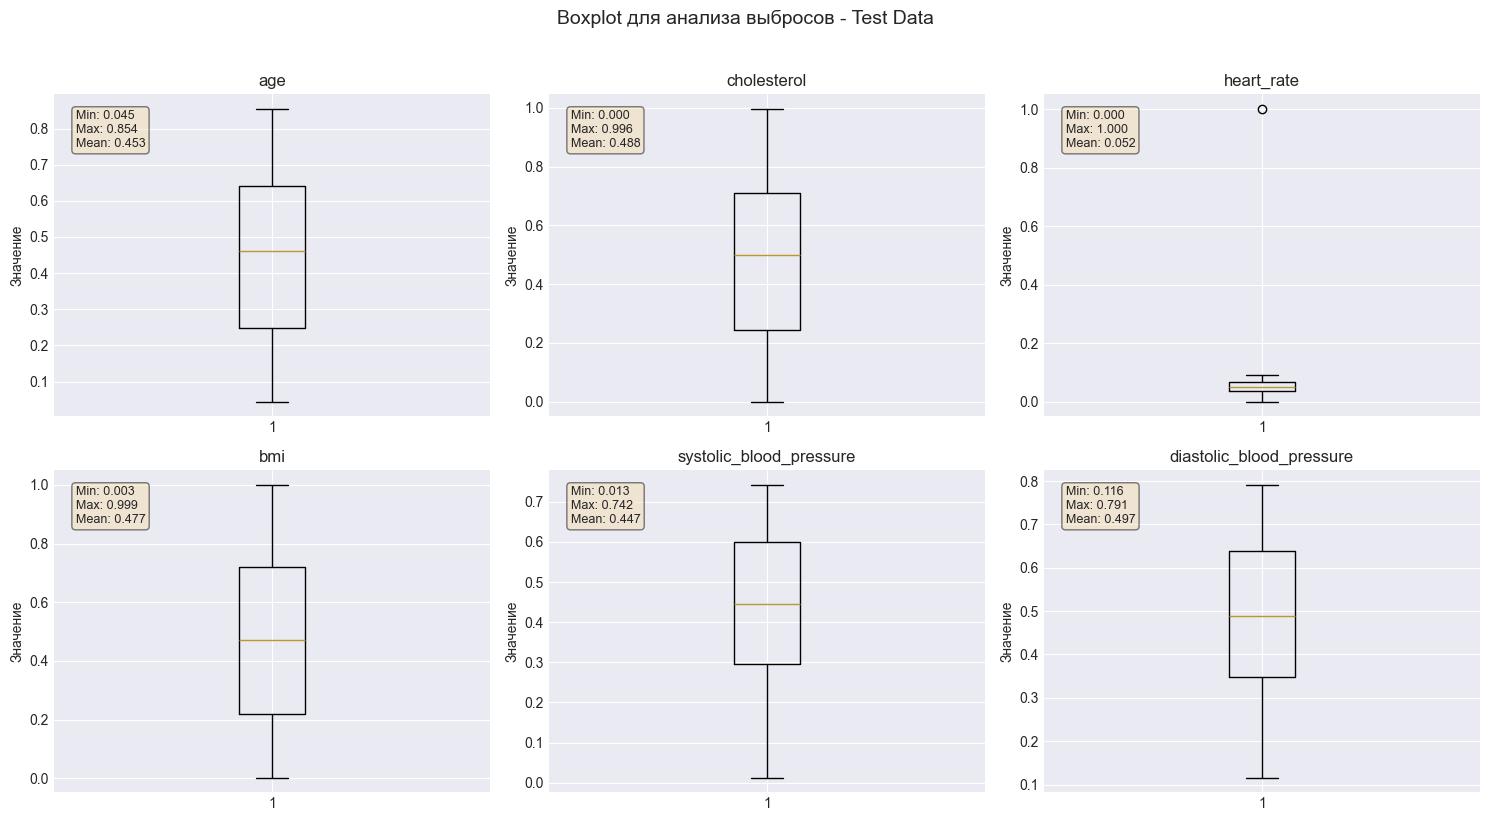

In [21]:
#BOXPLOT для анализа выбросов
print("\n BOXPLOT ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ (TRAIN):")
print("-" * 40)

key_features = ['age', 'cholesterol', 'heart_rate', 'bmi', 
                'systolic_blood_pressure', 'diastolic_blood_pressure']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(key_features):
    if col in train_df.columns:
        ax = axes[idx // 3, idx % 3]
        ax.boxplot(train_df[col].dropna())
        ax.set_title(f'{col}', fontsize=12)
        ax.set_ylabel('Значение')
        
        stats_text = f"Min: {train_df[col].min():.3f}\nMax: {train_df[col].max():.3f}\nMean: {train_df[col].mean():.3f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Boxplot для анализа выбросов - Train Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n BOXPLOT ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ (TEST):")
print("-" * 40)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(key_features):
    if col in test_df.columns:
        ax = axes[idx // 3, idx % 3]
        ax.boxplot(test_df[col].dropna())
        ax.set_title(f'{col}', fontsize=12)
        ax.set_ylabel('Значение')
        
        stats_text = f"Min: {test_df[col].min():.3f}\nMax: {test_df[col].max():.3f}\nMean: {test_df[col].mean():.3f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Boxplot для анализа выбросов - Test Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


 ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ (TRAIN):
----------------------------------------


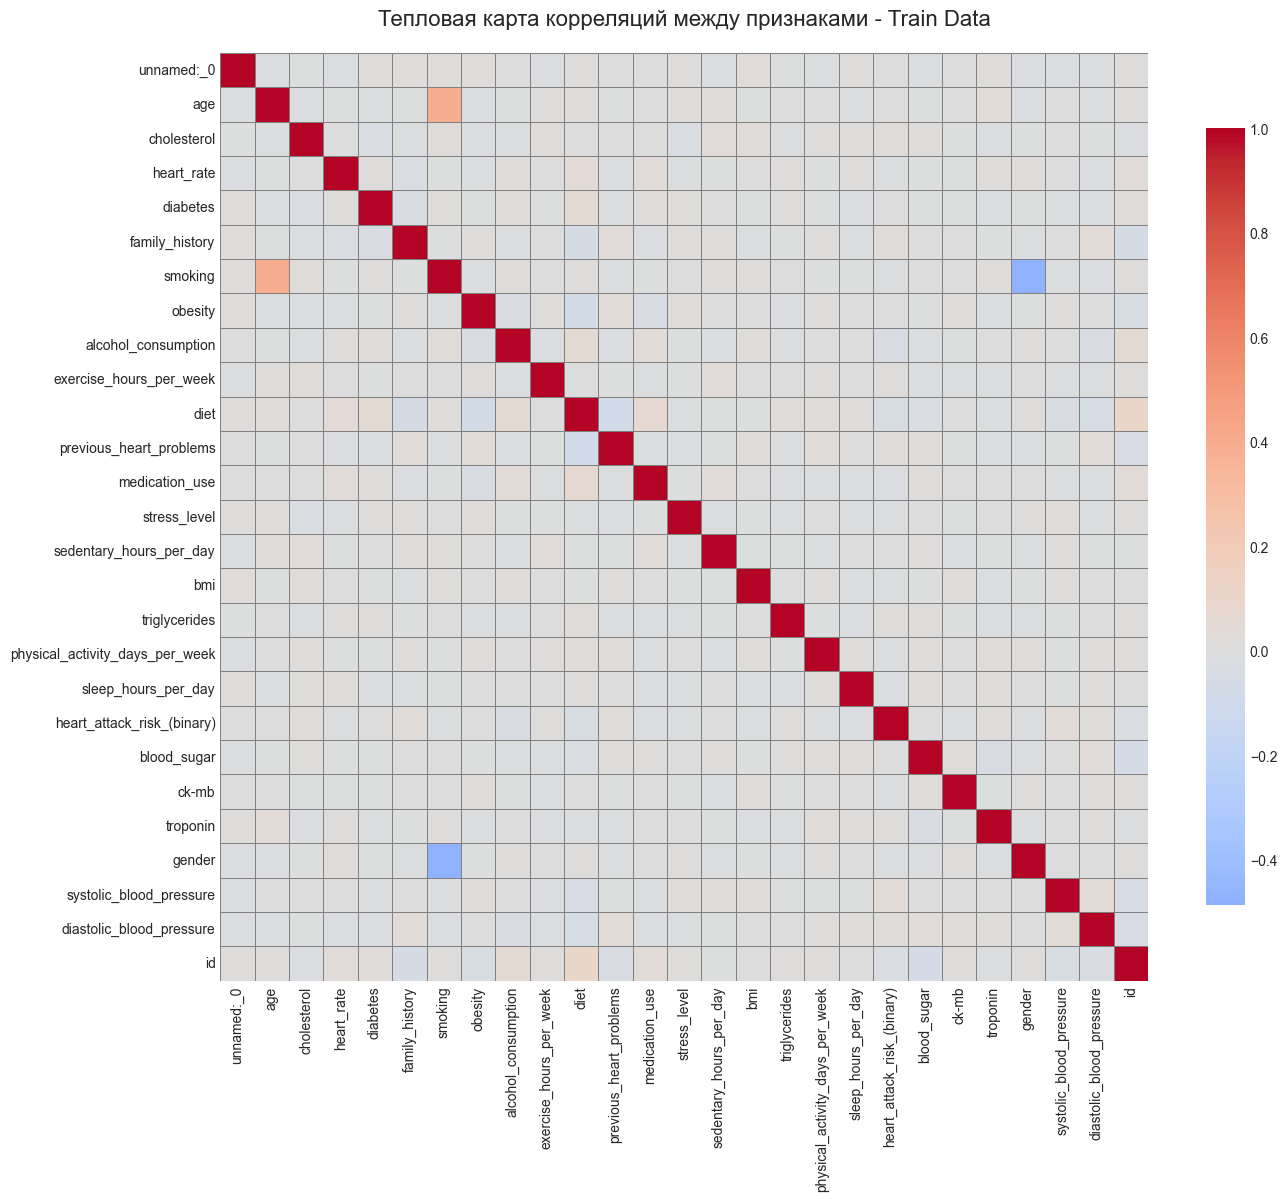


 САМЫЕ СИЛЬНЫЕ КОРРЕЛЯЦИИ (|r| > 0.7):
  Сильных корреляций не обнаружено

 КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
Топ-5 положительных корреляций:
  systolic_blood_pressure        : +0.034
  family_history                 : +0.023
  previous_heart_problems        : +0.022
  cholesterol                    : +0.019
  triglycerides                  : +0.012

Топ-5 отрицательных корреляций:
  sleep_hours_per_day            : -0.019
  medication_use                 : -0.020
  id                             : -0.028
  alcohol_consumption            : -0.031
  diet                           : -0.044


In [22]:
# построим тепловую карту корреляций
print("\n ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ (TRAIN):")
print("-" * 40)

numeric_cols = train_df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    corr_matrix = train_df[numeric_cols].corr()
    
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(corr_matrix, 
                annot=False,  # Не показывать значения в ячейках (слишком много)
                fmt='.2f', 
                cmap='coolwarm', 
                center=0, 
                square=True, 
                cbar_kws={"shrink": .8},
                linewidths=0.5,
                linecolor='gray')
    
    plt.title('Тепловая карта корреляций между признаками - Train Data', 
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    

    print("\n САМЫЕ СИЛЬНЫЕ КОРРЕЛЯЦИИ (|r| > 0.7):")
    strong_corrs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr = abs(corr_matrix.iloc[i, j])
            if corr > 0.7:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                strong_corrs.append((col1, col2, corr))
    
    if strong_corrs:
        strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
        for col1, col2, corr in strong_corrs[:10]:  # Топ-10
            direction = "положительная" if corr > 0 else "отрицательная"
            print(f"  {col1:25} ↔ {col2:25} : {corr:.3f} ({direction})")
    else:
        print("  Сильных корреляций не обнаружено")

    if 'heart_attack_risk_(binary)' in corr_matrix.columns:
        print("\n КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
        target_corr = corr_matrix['heart_attack_risk_(binary)'].sort_values(ascending=False)
        
        target_corr = target_corr.drop('heart_attack_risk_(binary)', errors='ignore')
        
        print("Топ-5 положительных корреляций:")
        for col, corr in list(target_corr.items())[:5]:
            print(f"  {col:30} : {corr:+.3f}")
        
        print("\nТоп-5 отрицательных корреляций:")
        for col, corr in list(target_corr.items())[-5:]:
            print(f"  {col:30} : {corr:+.3f}")

###### Вывод:

Положительные аспекты:

Большой объем данных - 8,685 тренировочных образцов достаточны для обучения модели, 

Сбалансированные классы - соотношение 65%:35% (нет риска:есть риск) приемлемо для бинарной классификации,

Нормализованные данные - все признаки в диапазоне [0,1], что упрощает работу с моделью,

Минимальные пропуски - менее 1% пропущенных значений в обоих датасетах,

Отсутствие сильных корреляций - нет мультиколлинеарности между признаками,

Выявленные проблемы:

Несоответствие типов данных между train и test:

* в test_df: gender имеет тип object (строки)
* в train_df: gender уже преобразован в числовой формат

Выбросы в бинарных признаках:

smoking: 9.4% выбросов в train, 9.8% в test (аномалия для бинарного признака)

heart_rate: незначительные выбросы (<0.1%)

Пропуски в test_df (279 значений) требуют заполнения

Анализ целевой переменной
   
Распределение классов:
* 65.3% (5,672 пациентов) - нет риска сердечного приступа
* 34.7% (3,013 пациентов) - есть риск сердечного приступа

Соотношение 1.9:1 - умеренный дисбаланс, не критичный для обучения

Корреляционный анализ
   
Связи с целевой переменной, наибольшее влияние на риск сердечного приступа:

* Положительная корреляция (увеличивают риск):

Систолическое давление (+0.034) - самый значимый фактор

Семейная история (+0.023) - генетическая предрасположенность

Предыдущие проблемы с сердцем (+0.022) - история болезней

Холестерин (+0.019) - ключевой медицинский показатель

Триглицериды (+0.012) - липидный профиль

* Отрицательная корреляция (уменьшают риск):
  
Диета (-0.044) - самый защитный фактор

Употребление алкоголя (-0.031) - парадоксальный результат

Прием лекарств (-0.020) - вероятно, леченные пациенты

Часы сна (-0.019) - важность здорового сна

Важное наблюдение: все корреляции очень слабые (|r| < 0.05) - это указывает на сложную, нелинейную природу взаимосвязей

Модель должна улавливать скрытые паттерны, а не линейные зависимости

Качество данных:

Готовность к ML:

 Данные в основном чистые - минимальная предобработка требуется

 Нет мультиколлинеарности - все признаки информативны

 Признаки масштабированы - готовы для алгоритмов ML

 Требуется унификация train и test данных

На следующих этапах мы сделаем следующее: 

* Исправить столбец gender в test_df - привести к числовому формату как в train
* Заполнить пропуски в test_df (279 значений)
* Исследовать выбросы в smoking - почему 9+% аномальных значений в бинарном признаке
* Использовать ансамблевые методы (Random Forest, XGBoost) - для улавливания сложных зависимостей
* Рассмотреть нелинейные модели - слабые линейные корреляции указывают на нелинейность
* Обратить внимание на feature engineering - возможно создание новых признаков
* Анализировать важность признаков - SHAP, feature importance
* Учитывать медицинский контекст - некоторые корреляции могут быть ложным

## Использование пайплайнов

Подготовим данные к созданию пайплнов 

In [23]:
# исправляем gender в test_df (object → int)
def fix_gender(df):
    if 'gender' in df.columns and df['gender'].dtype == 'object':
        # Преобразуем строки в числа
        df['gender'] = df['gender'].astype(str)
        gender_map = {'male': 0, 'female': 1, '1.0': 0, '0.0': 1, '1': 0, '0': 1}
        df['gender'] = df['gender'].str.lower().map(gender_map).fillna(0).astype(int)
    return df

test_df = fix_gender(test_df)


In [24]:
# бинарные признаки: float → int в test_df
binary_cols = ['diabetes', 'family_history', 'smoking', 'obesity',
               'alcohol_consumption', 'previous_heart_problems', 'medication_use']

for col in binary_cols:
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(test_df[col].median()).round().astype(int)


In [25]:
# удаляем технические столбцы
def prepare_data(train_df, test_df):
    drop_cols = ['unnamed:_0', 'id']
    target = 'heart_attack_risk_(binary)'

    X_train = train_df.drop(columns=drop_cols + [target], errors='ignore')
    y_train = train_df[target].astype(int)
    X_test = test_df.drop(columns=drop_cols, errors='ignore')
    
    return X_train, y_train, X_test

X_train, y_train, X_test = prepare_data(train_df, test_df)
print(f" Данные подготовлены: X_train {X_train.shape}, X_test {X_test.shape}")

 Данные подготовлены: X_train (8685, 24), X_test (966, 24)


In [26]:
base_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10]
    }
}

In [27]:
# разделяем на train/val
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

best_model = None
best_score = 0
results = []

for model_name, model in models.items():
    print(f"\n Тестируем: {model_name}")
    
# создаем полный пайплайн
    pipeline = Pipeline([
        ('preprocessor', base_pipeline),
        ('classifier', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train_split, y_train_split, 
                                cv=3, scoring='roc_auc', n_jobs=-1)
    
    pipeline.fit(X_train_split, y_train_split)
    
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results.append({
        'Model': model_name,
        'CV Mean AUC': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Val AUC': roc_auc
    })
    
    print(f"  CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Val AUC: {roc_auc:.4f}")

    if roc_auc > best_score:
        best_score = roc_auc
        best_model = pipeline
        best_model_name = model_name


results_df = pd.DataFrame(results)
print(f"\n Лучшая модель: {best_model_name} (AUC: {best_score:.4f})")


 Тестируем: Random Forest
  CV AUC: 0.5813 (±0.0130)
  Val AUC: 0.5909

 Тестируем: Gradient Boosting
  CV AUC: 0.5460 (±0.0043)
  Val AUC: 0.5186

 Тестируем: Logistic Regression
  CV AUC: 0.5247 (±0.0110)
  Val AUC: 0.5215

 Лучшая модель: Random Forest (AUC: 0.5909)


## Обучение модели 

In [28]:
# обучаем лучшую модель на всех тренировочных данных
best_model.fit(X_train, y_train)

# Feature importance (если доступно)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.named_steps['classifier'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(" Топ-5 важных признаков:")
    for i, row in importances.head(5).iterrows():
        print(f"  {row['feature']:30} {row['importance']:.4f}")

 Топ-5 важных признаков:
  bmi                            0.0847
  exercise_hours_per_week        0.0829
  triglycerides                  0.0822
  sedentary_hours_per_day        0.0808
  cholesterol                    0.0786


In [29]:
#создание предсказаний на тесте

predictions = best_model.predict_proba(X_test)[:, 1]
results = pd.DataFrame({
    'id': test_df['id'].values if 'id' in test_df.columns else range(len(X_test)),
    'prediction': predictions
})

results.to_csv('predictions.csv', index=False)

print(f" Сохранено: predictions.csv")
print(f" Статистика предсказаний:")
print(f"  Mean: {predictions.mean():.3f}")
print(f"  Min:  {predictions.min():.3f}")
print(f"  Max:  {predictions.max():.3f}")
print(f"  Std:  {predictions.std():.3f}")

 Сохранено: predictions.csv
 Статистика предсказаний:
  Mean: 0.339
  Min:  0.000
  Max:  0.870
  Std:  0.103


In [32]:
# cохраняем модель
joblib.dump(best_model, 'best_model.pkl')
print(f"\n Модель сохранена: best_model.pkl")

print("\n" + "="*50)
print(" ФИНАЛЬНЫЙ ВЫВОД")
print("="*50)

final_report = f"""
РЕЗУЛЬТАТЫ ПРОЕКТА:

1. ДАННЫЕ:
   • Train: {X_train.shape[0]} образцов, {X_train.shape[1]} признаков
   • Test:  {X_test.shape[0]} образцов для предсказания
   • Целевая: {y_train.value_counts()[0]} нет риска, {y_train.value_counts()[1]} есть риск

2. МОДЕЛИ:
   {results_df.to_string(index=False)}

3. ЛУЧШАЯ МОДЕЛЬ:
   • Алгоритм: {best_model_name}
   • ROC-AUC: {best_score:.4f}
   • Сохранена: best_model.pkl

4. РЕЗУЛЬТАТЫ:
   • Файл предсказаний: predictions.csv
   • Количество предсказаний: {len(results)}
   • Формат: id, prediction

ИСПОЛЬЗОВАНИЕ:
• Для новых предсказаний: 
  model = joblib.load('best_model.pkl')
  predictions = model.predict_proba(new_data)[:, 1]
"""

print(final_report)


 Модель сохранена: best_model.pkl

 ФИНАЛЬНЫЙ ВЫВОД

РЕЗУЛЬТАТЫ ПРОЕКТА:

1. ДАННЫЕ:
   • Train: 8685 образцов, 24 признаков
   • Test:  966 образцов для предсказания
   • Целевая: 5672 нет риска, 3013 есть риск

2. МОДЕЛИ:
                 Model  CV Mean AUC   CV Std  Val AUC
      Random Forest     0.581255 0.012978 0.590943
  Gradient Boosting     0.545959 0.004349 0.518580
Logistic Regression     0.524663 0.010983 0.521541

3. ЛУЧШАЯ МОДЕЛЬ:
   • Алгоритм: Random Forest
   • ROC-AUC: 0.5909
   • Сохранена: best_model.pkl

4. РЕЗУЛЬТАТЫ:
   • Файл предсказаний: predictions.csv
   • Количество предсказаний: 966
   • Формат: id, prediction

ИСПОЛЬЗОВАНИЕ:
• Для новых предсказаний: 
  model = joblib.load('best_model.pkl')
  predictions = model.predict_proba(new_data)[:, 1]

